## Import all what we need

In [27]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, AveragePooling2D, Embedding, Masking
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

import os
from os import path, getcwd, chdir
import random
import pickle

from shutil import copyfile
from zipfile import ZipFile


2.4.1


## Load data with os,zipfile

In [2]:
DataDirForest = '/kaggle/input/d/kutaykutlu/forest-fire'
DataDirFire = '/kaggle/input/fire-dataset/fire_dataset'
DataDirFireExt = '/kaggle/input/forest-fire/FIRE_DATASET'


print(os.listdir(DataDirForest))
print(os.listdir(DataDirFire))
print(os.listdir(DataDirFireExt))

['train_fire', 'test_big', 'test_small', 'train-smoke']
['non_fire_images', 'fire_images']
['non_fire_images', 'fire_images']


In [3]:
to_making_dir = [
    '/tmp/smoke-fire',
    '/tmp/smoke-fire/fire',
    '/tmp/smoke-fire/smoke',
    '/tmp/smoke-fire/natural'
]
for directory in to_making_dir:
    try:
        os.mkdir(directory)
    except OSError:
        pass
    


In [4]:
print(os.listdir('/tmp/smoke-fire/'))
# os.rmdir('tmp/smoke-fire/testing')
# os.rmdir('tmp/smoke-fire/training')

['natural', 'fire', 'smoke']


In [5]:
FIRE_DIR = '/tmp/smoke-fire/fire'

SMOKE_DIR = '/tmp/smoke-fire/smoke'

NATURAL_DIR = '/tmp/smoke-fire/natural'



In [6]:
def copy_file(src, dst):
    for f in os.listdir(src):
        file_dir = src +f
        dest_dir = dst +'/'+f
        copyfile(file_dir, dest_dir)
        
copy_file(DataDirForest + '/train_fire/', FIRE_DIR)
copy_file(DataDirFire + '/fire_images/', FIRE_DIR)
copy_file(DataDirFireExt + '/fire_images/', FIRE_DIR)

copy_file(DataDirForest + '/train-smoke/', SMOKE_DIR)

copy_file(DataDirFire + '/non_fire_images/', NATURAL_DIR)
copy_file(DataDirFireExt + '/non_fire_images/', NATURAL_DIR)

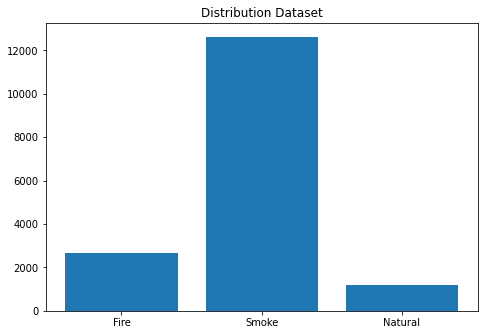

In [7]:
fire = len(os.listdir(FIRE_DIR))
smoke = len(os.listdir(SMOKE_DIR))
natural = len(os.listdir(NATURAL_DIR))

len(os.listdir(SMOKE_DIR))
len(os.listdir(FIRE_DIR))


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Distribution Dataset')
label = ['Fire', 'Smoke', 'Natural']
data = [fire, smoke, natural]
ax.bar(label,data)

plt.show()

### Pre trained model or Transfer learning

# Split data

## Preprocessing data

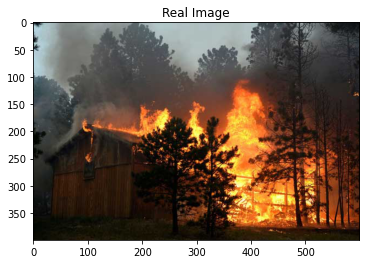

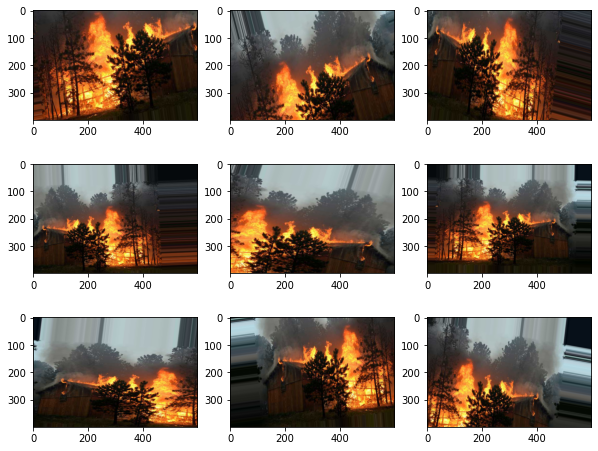

In [40]:
ex_img = DataDirForest + '/train_fire/20130611_100618_Black-Forest-Fire-engulfs-house.jpg'

img = load_img(ex_img)
img_arr = img_to_array(img)
plt.title('Real Image')
plt.imshow(img)
new_img = np.expand_dims(img_arr, 0)
imageDataGen = ImageDataGenerator(horizontal_flip=True,
                                  zoom_range = 0.4,
                                  rotation_range=20,    
                                  featurewise_center=True,
                                  featurewise_std_normalization=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  validation_split=0.2,
                                  shear_range = 0.2,
                                  fill_mode = 'nearest'            
)
iterate = imageDataGen.flow(new_img, batch_size=1)

plt.figure(figsize=(10, 8))

for i in range(9):
  plt.subplot(330  + 1 + i)
  batch = iterate.next()
  picture = batch[0].astype('uint8')
  plt.imshow(picture)
plt.show()

In [9]:
BASE_DIR = '/tmp/smoke-fire'
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=16,
    save_format="png",
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=16,
    save_format="png",
    subset='validation'
)


Found 13168 images belonging to 3 classes.
Found 3290 images belonging to 3 classes.


### Image data preprocessing

### Standardize the data

### Configure the dataset for performance

## Learning

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training")
            self.model.stop_training = True

In [12]:
def lr_scheduler(epochs, lr):
    if epochs > 50 and epochs < 75:
        lr = 0.001
    if epochs > 75:
        lr = 0.0001
    return lr

In [13]:
callbacks = myCallback()

In [14]:
scheduler = LearningRateScheduler(lr_scheduler, verbose=1)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)), #must pay attention to input_shape and '16, (3, 3)' is filter 6 and kernel is 3
    tf.keras.layers.MaxPooling2D(2,2), #make the model minimalist by reducing a number of parameters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
]) 

In [16]:
model.compile(optimizer = tf.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [ ]:
  %reload_ext tensorboard

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=16,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=4,
    verbose=2,
    callbacks=[callbacks]
)

# model fitting
return history.epoch, history.history['accuracy'][-1]

Epoch 1/40
16/16 - 19s - loss: 1.1284 - accuracy: 0.6172 - val_loss: 0.5689 - val_accuracy: 0.7969
Epoch 2/40
16/16 - 9s - loss: 0.4449 - accuracy: 0.8594 - val_loss: 0.3271 - val_accuracy: 0.9062
Epoch 3/40
16/16 - 9s - loss: 0.3229 - accuracy: 0.9023 - val_loss: 0.4060 - val_accuracy: 0.8281
Epoch 4/40
16/16 - 8s - loss: 0.3150 - accuracy: 0.9219 - val_loss: 0.3577 - val_accuracy: 0.8438
Epoch 5/40
16/16 - 9s - loss: 0.2572 - accuracy: 0.9180 - val_loss: 0.2396 - val_accuracy: 0.8750
Epoch 6/40
16/16 - 9s - loss: 0.2362 - accuracy: 0.9297 - val_loss: 0.2600 - val_accuracy: 0.8750
Epoch 7/40
16/16 - 10s - loss: 0.3297 - accuracy: 0.8984 - val_loss: 0.4349 - val_accuracy: 0.8125
Epoch 8/40
16/16 - 8s - loss: 0.3462 - accuracy: 0.8906 - val_loss: 0.2302 - val_accuracy: 0.9062
Epoch 9/40
16/16 - 8s - loss: 0.1686 - accuracy: 0.9453 - val_loss: 0.1973 - val_accuracy: 0.9062
Epoch 10/40
16/16 - 9s - loss: 0.2266 - accuracy: 0.9336 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 11/40
16/16

SyntaxError: 'return' outside function (<ipython-input-18-cd047d66f165>, line 12)

### Save checkpoints during training

### rebuild a fresh
untrained model and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy):

### load the weights from the checkpoint and re-evaluate:

### Checkpoint callback options

## Evaluate Model

### Visualizing the Convolutions and Pooling

### Visualizing Intermediate Representations

### Evaluating Accuracy and Loss for the Model

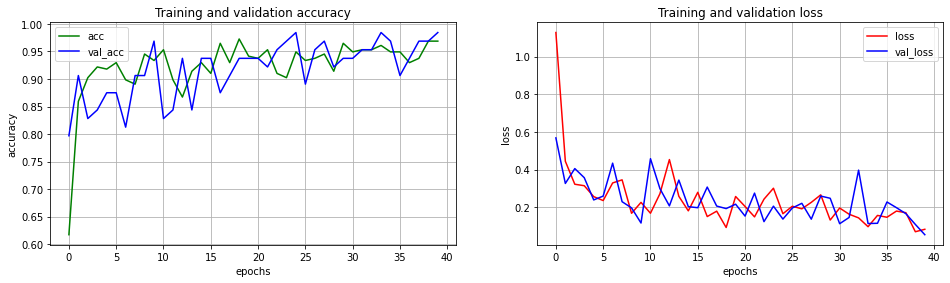

In [19]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.figure(figsize=(16,9))
plt.subplot(221)

plt.grid(True)
plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc, 'b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='best')
plt.title('Training and validation accuracy')

plt.subplot(222)
plt.grid(True)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Training and validation loss')

plt.show()

In [22]:
acc=history.history['accuracy']

print('Test accuracy:', acc)

Test accuracy: [0.6171875, 0.859375, 0.90234375, 0.921875, 0.91796875, 0.9296875, 0.8984375, 0.890625, 0.9453125, 0.93359375, 0.953125, 0.8984375, 0.8671875, 0.9140625, 0.9296875, 0.91015625, 0.96484375, 0.9296875, 0.97265625, 0.94140625, 0.9375, 0.953125, 0.91015625, 0.90234375, 0.94921875, 0.93359375, 0.9375, 0.9453125, 0.9140625, 0.96484375, 0.94921875, 0.953125, 0.953125, 0.9609375, 0.94921875, 0.94921875, 0.9296875, 0.9375, 0.96875, 0.96875]


In [57]:
test_image_luna= load_img('../input/testimagenes/fire.jpg',target_size=(150,150))
test_image2= img_to_array(test_image_luna)
test_image2=np.expand_dims(test_image2,axis=0)
luna=model.predict(test_image2)
luna2=model.predict(test_image22)
luna3=model.predict(test_image3)

test_image_luna2= load_img('../input/testimagenes/for.jpg',target_size=(150,150))
test_image22= img_to_array(test_image_luna2)
test_image22=np.expand_dims(test_image22,axis=0)
luna2=model.predict(test_image22)

test_image_luna3= load_img('../input/testimagenes/smoke.jpg',target_size=(150,150))
test_image3= img_to_array(test_image_luna3)
test_image3=np.expand_dims(test_image3,axis=0)
luna3=model.predict(test_image3)

luna=model.predict(test_image2)
# [fire, natural, smoke]
print(luna)
print(luna2)
print(luna3)

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


In [59]:
model.save('forest-fire.h5')